ergrant jborromeo SYDE 552 Final Project

code reference: https://www.nengo.ai/keras-spiking/examples/spiking-fashion-mnist.html

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import keras_spiking

tf.random.set_seed(0)
np.random.seed(0)

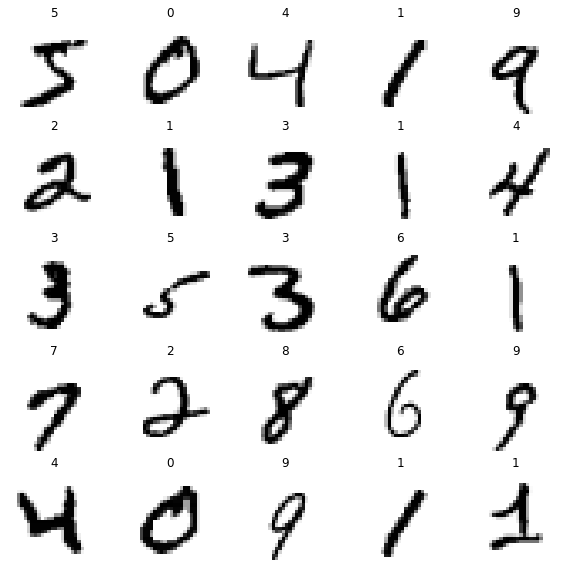

In [6]:
# Load MNIST Digits Dataset
((train_images, train_labels),(test_images, test_labels),) = tf.keras.datasets.mnist.load_data()
#train_labels = train_labels.squeeze()
#test_labels = test_labels.squeeze()

# maximum of each colour is 255
#print(np.max(train_images[0], axis=(0,1)))

# normalize images so values are between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

#class_names = [
#    "airplane",
#    "automobile",
#    "bird",
#    "cat",
#    "deer",
#    "dog",
#    "frog",
#    "horse",
#    "ship",
#    "truck",
#]

class_names = [
    "0",
    "1",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9"
]

num_classes = len(class_names)

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.axis("off")
    plt.title(class_names[train_labels[i]])

## Non-Spiking Model for Comparison

In [7]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=train_images.shape[1:]),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(num_classes),
    ]
)


def train(input_model, train_x, test_x):
    input_model.compile(
        optimizer="adam",
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )

    input_model.fit(train_x, train_labels, epochs=10)

    _, test_acc = input_model.evaluate(test_x, test_labels, verbose=2)


    print("\nTest accuracy:", test_acc)


train(model, train_images, test_images)

Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.4282 - accuracy: 0.8811
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1125 - accuracy: 0.9677
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0791 - accuracy: 0.9753
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0579 - accuracy: 0.9823
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0385 - accuracy: 0.9887
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0308 - accuracy: 0.9910
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0235 - accuracy: 0.9934
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0209 - accuracy: 0.9939
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0164 - accuracy: 0.9948
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.014

In [113]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


## Conversion to Spiking Model

In [9]:
# repeat the images for n_steps
n_steps = 10
train_sequences = np.tile(train_images[:, None], (1, n_steps, 1, 1))
test_sequences = np.tile(test_images[:, None], (1, n_steps, 1, 1))

In [10]:
print(train_sequences.shape)

(60000, 10, 28, 28)


In [11]:
spiking_model = tf.keras.Sequential(
    [
        # add temporal dimension to the input shape; we can set it to None,
        # to allow the model to flexibly run for different lengths of time
        tf.keras.layers.Reshape((-1, 28 * 28), input_shape=(None, 28, 28)),
        # we can use Keras' TimeDistributed wrapper to allow the Dense layer
        # to operate on temporal data
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128)),
        # replace the "relu" activation in the non-spiking model with a
        # spiking equivalent
        keras_spiking.SpikingActivation("relu", spiking_aware_training=False),
        # use average pooling layer to average spiking output over time
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(10),
    ]
)

# train the model, identically to the non-spiking version,
# except using the time sequences as inputs
train(spiking_model, train_sequences, test_sequences)

Epoch 1/10
1875/1875 [==============================] - 31s 16ms/step - loss: 0.4264 - accuracy: 0.8829
Epoch 2/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.1178 - accuracy: 0.9651
Epoch 3/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0808 - accuracy: 0.9756
Epoch 4/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0586 - accuracy: 0.9827
Epoch 5/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0411 - accuracy: 0.9874
Epoch 6/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0329 - accuracy: 0.9900
Epoch 7/10
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0243 - accuracy: 0.9929
Epoch 8/10
1875/1875 [==============================] - 29s 16ms/step - loss: 0.0217 - accuracy: 0.9936
Epoch 9/10
1875/1875 [==============================] - 29s 16ms/step - loss: 0.0170 - accuracy: 0.9951
Epoch 10/10
1875/1875 [==============================] - 29s 15m

In [144]:
spiking_model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
dir(spiking_model)
dir(spiking_model.layers[-1])
spiking_model.layers[-1].get_output_shape_at(44)

(None, None, 10)

In [80]:
def check_output(seq_model, modify_dt=None, plot=True):
    """
    This code is only used for plotting purposes, and isn't necessary to
    understand the rest of this example; feel free to skip it
    if you just want to see the results.
    """

    # rebuild the model with the functional API, so that we can
    # access the output of intermediate layers
    inp = x = tf.keras.Input(batch_shape=seq_model.layers[0].input_shape)

    has_global_average_pooling = False
    for layer in seq_model.layers:
        if isinstance(layer, tf.keras.layers.GlobalAveragePooling1D):
            # remove the pooling so that we can see the model's
            # output over time
            has_global_average_pooling = True
            continue

        if isinstance(layer, (keras_spiking.SpikingActivation, keras_spiking.Lowpass)):
            cfg = layer.get_config()
            # update dt, if specified
            if modify_dt is not None:
                cfg["dt"] = modify_dt
            # always return the full time series so we can visualize it
            cfg["return_sequences"] = True

            layer = type(layer)(**cfg)

        if isinstance(layer, keras_spiking.SpikingActivation):
            # save this layer so we can access it later
            spike_layer = layer

        x = layer(x)

    func_model = tf.keras.Model(inp, [x, spike_layer.output])

    # copy weights to new model
    func_model.set_weights(seq_model.get_weights())

    # run model
    output, spikes = func_model.predict(test_sequences)

    if has_global_average_pooling:
        # check test accuracy using average output over all timesteps
        predictions = np.argmax(output.mean(axis=1), axis=-1)
    else:
        # check test accuracy using output from only the last timestep
        predictions = np.argmax(output[:, -1], axis=-1)
    accuracy = np.equal(predictions, test_labels).mean()
    print("Test accuracy: %.2f%%" % (100 * accuracy))

    time = test_sequences.shape[1] * spike_layer.dt
    n_spikes = spikes * spike_layer.dt
    rates = np.sum(n_spikes, axis=1) / time

    print(
        "Spike rate per neuron (Hz): min=%.2f mean=%.2f max=%.2f"
        % (np.min(rates), np.mean(rates), np.max(rates))
    )

    if plot:
        # plot output
        for ii in range(4):
            plt.figure(figsize=(12, 4))

            plt.subplot(1, 3, 1)
            plt.title(class_names[test_labels[ii]])
            plt.imshow(test_images[ii], cmap="gray")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.title("Spikes per neuron per timestep")
            bin_edges = np.arange(int(np.max(n_spikes[ii])) + 2) - 0.5
            plt.hist(np.ravel(n_spikes[ii]), bins=bin_edges)
            x_ticks = plt.xticks()[0]
            plt.xticks(
                x_ticks[(np.abs(x_ticks - np.round(x_ticks)) < 1e-8) & (x_ticks > -1e-8)]
            )
            plt.xlabel("# of spikes")
            plt.ylabel("Frequency")

            plt.subplot(1, 3, 3)
            plt.title("Output predictions")
            plt.plot(
                np.arange(test_sequences.shape[1]) * spike_layer.dt,
                tf.nn.softmax(output[ii]),
            )
            plt.legend(class_names, loc="upper left")
            plt.xlabel("Time (s)")
            plt.ylabel("Probability")
            plt.ylim([-0.05, 1.05])

            plt.tight_layout()
    return 100 * accuracy

Test accuracy: 18.19%
Spike rate per neuron (Hz): min=0.00 mean=0.91 max=100.00


18.19

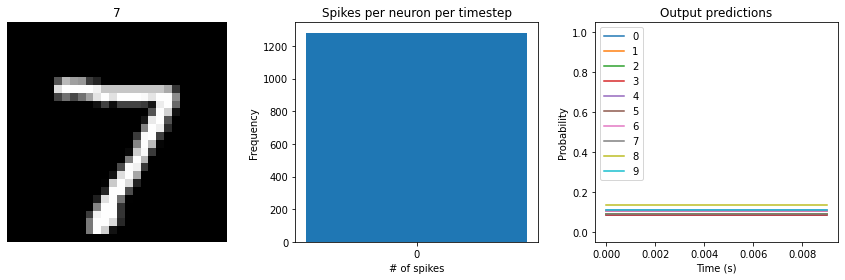

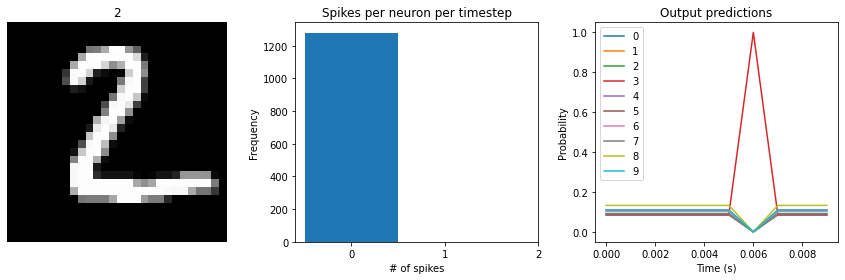

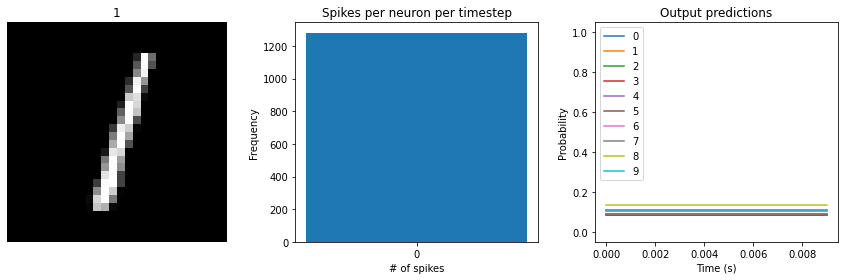

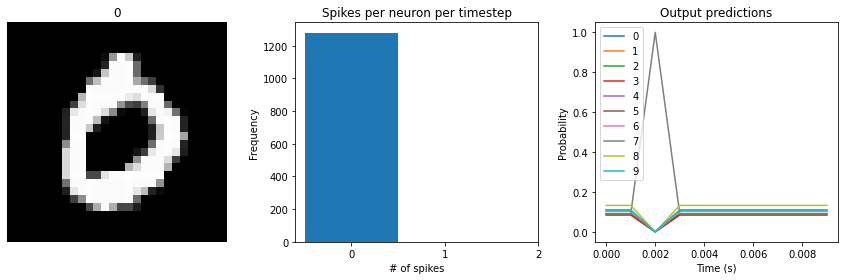

In [13]:
check_output(spiking_model)

Test accuracy: 70.97%
Spike rate per neuron (Hz): min=0.00 mean=0.93 max=20.00


70.97

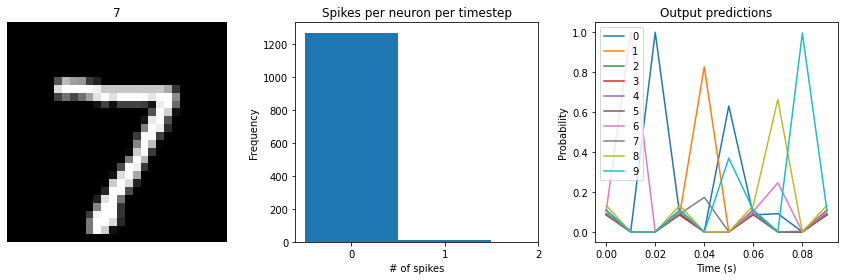

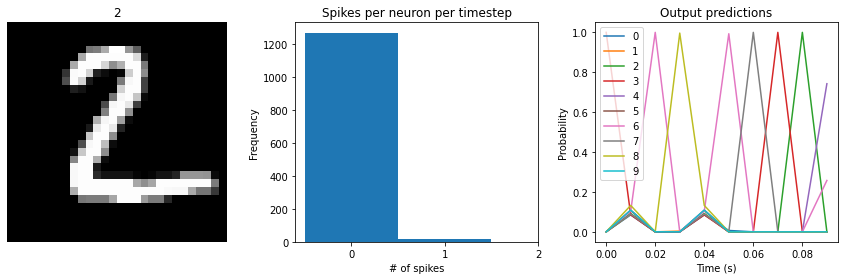

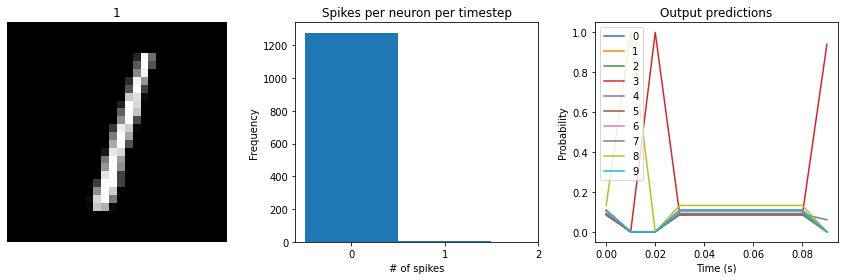

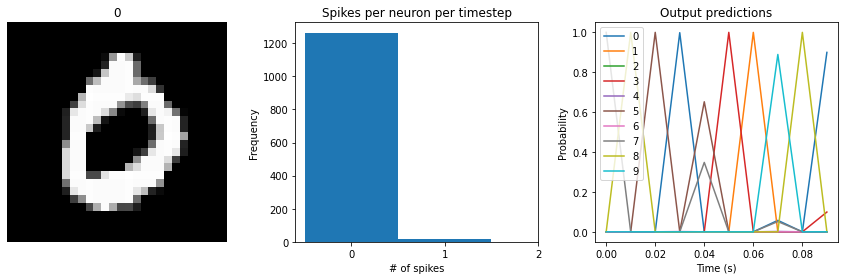

In [14]:
# Note that you don't have to re-train the model to increase the accuracy

# dt=0.01 * 10 timesteps is equivalent to 0.1s of simulated time
check_output(spiking_model, modify_dt=0.01)

Test accuracy: 97.74%
Spike rate per neuron (Hz): min=0.00 mean=0.94 max=17.00


97.74000000000001

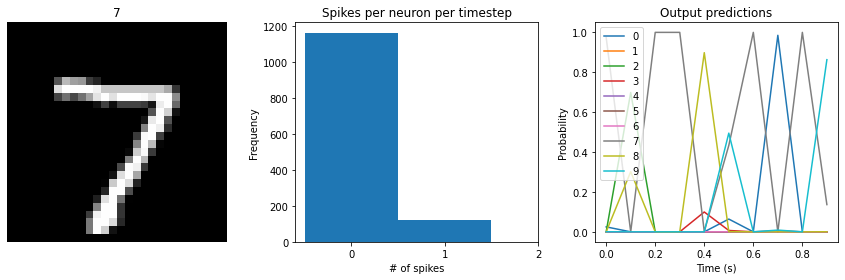

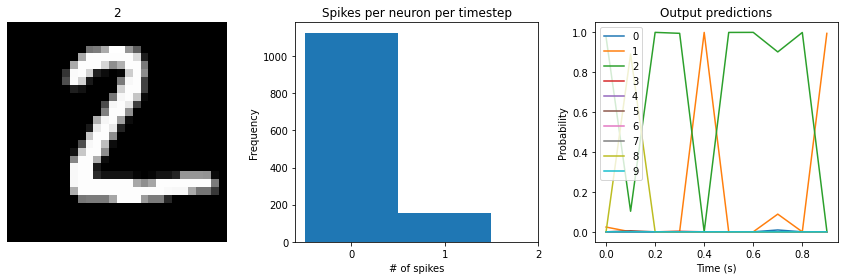

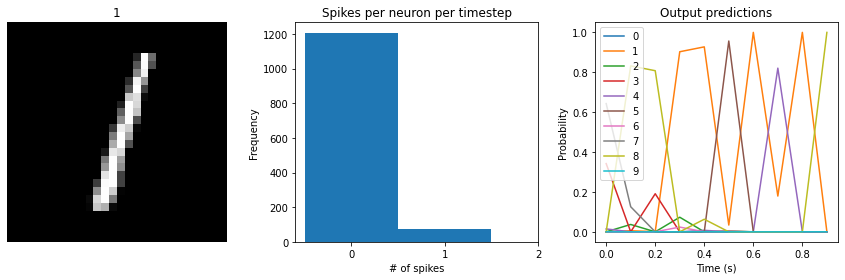

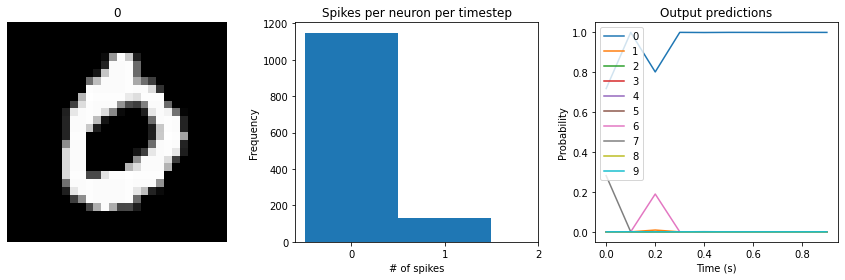

In [15]:
check_output(spiking_model, modify_dt=0.1)

Test accuracy: 97.88%
Spike rate per neuron (Hz): min=0.00 mean=0.94 max=16.90


97.88

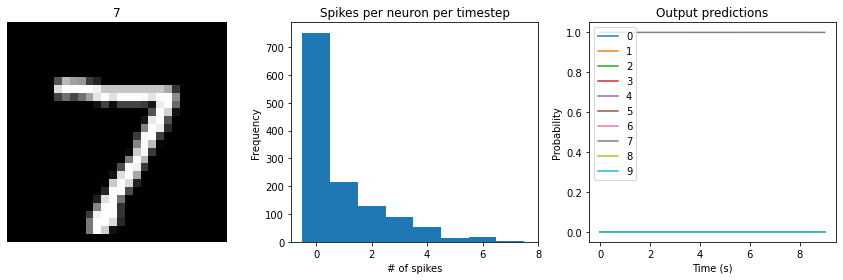

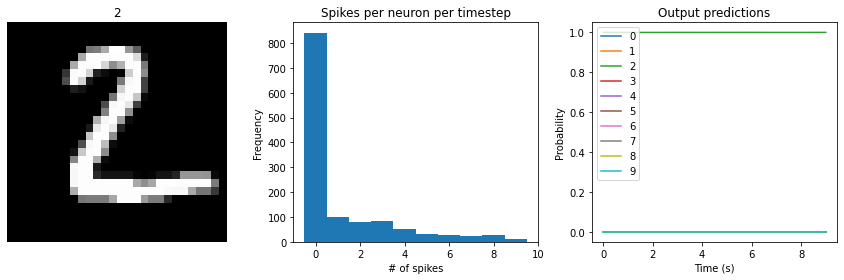

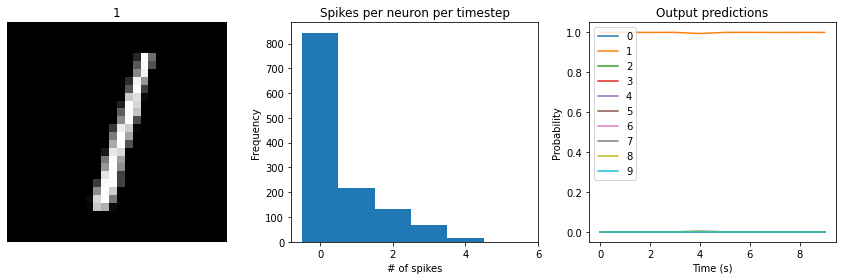

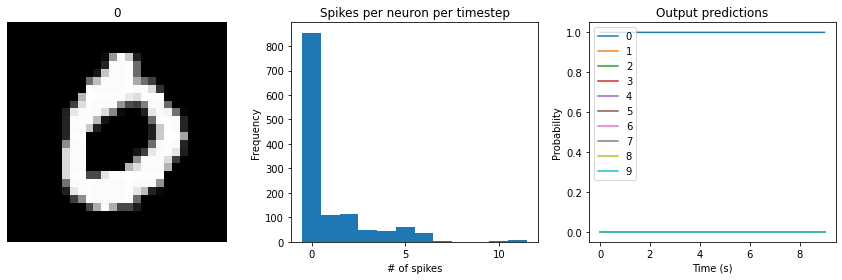

In [16]:
check_output(spiking_model, modify_dt=1)

In [98]:
dts = [0.001,0.002, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.5, 1]
accuracies = []

for dt in dts:
    acc = check_output(spiking_model, modify_dt=dt, plot=False)
    accuracies.append(acc)
    

Test accuracy: 18.19%
Spike rate per neuron (Hz): min=0.00 mean=0.91 max=100.00
Test accuracy: 26.74%
Spike rate per neuron (Hz): min=0.00 mean=0.92 max=50.00
Test accuracy: 48.38%
Spike rate per neuron (Hz): min=0.00 mean=0.93 max=20.00
Test accuracy: 70.97%
Spike rate per neuron (Hz): min=0.00 mean=0.93 max=20.00
Test accuracy: 89.85%
Spike rate per neuron (Hz): min=0.00 mean=0.94 max=20.00
Test accuracy: 94.92%
Spike rate per neuron (Hz): min=0.00 mean=0.94 max=16.67
Test accuracy: 96.48%
Spike rate per neuron (Hz): min=0.00 mean=0.94 max=17.50
Test accuracy: 97.04%
Spike rate per neuron (Hz): min=0.00 mean=0.94 max=18.00
Test accuracy: 97.74%
Spike rate per neuron (Hz): min=0.00 mean=0.94 max=17.00
Test accuracy: 97.87%
Spike rate per neuron (Hz): min=0.00 mean=0.94 max=16.80
Test accuracy: 97.88%
Spike rate per neuron (Hz): min=0.00 mean=0.94 max=16.90


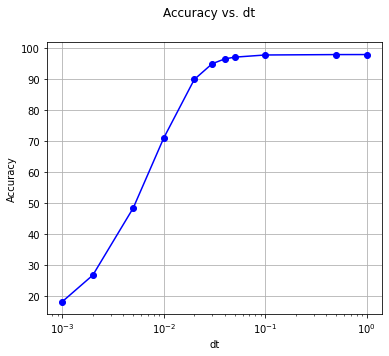

In [99]:
fig, ax = plt.subplots(figsize=(6,5))

ax.plot(dts, accuracies, '-bo')
ax.grid()

ax.set_xscale('log')

plt.suptitle('Accuracy vs. dt')
ax.set_ylabel('Accuracy')
ax.set_xlabel('dt')

plt.show()

In [109]:
aware_accuracies = []

for dt in dts:
    
    spike_aware_model = tf.keras.Sequential(
        [
            # add temporal dimension to the input shape; we can set it to None,
            # to allow the model to flexibly run for different lengths of time
            tf.keras.layers.Reshape((-1, 28 * 28), input_shape=(None, 28, 28)),
            # we can use Keras' TimeDistributed wrapper to allow the Dense layer
            # to operate on temporal data
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128)),
            # replace the "relu" activation in the non-spiking model with a
            # spiking equivalent
            keras_spiking.SpikingActivation("relu", dt = dt, spiking_aware_training=True),
            # use average pooling layer to average spiking output over time
            tf.keras.layers.GlobalAveragePooling1D(),
            tf.keras.layers.Dense(10),
        ]
    )


    # train the model, identically to the non-spiking version,
    # except using the time sequences as inputs
    train(spike_aware_model, train_sequences, test_sequences)
    
    acc = check_output(spike_aware_model, plot=False)
    aware_accuracies.append(acc)

Epoch 1/10
1875/1875 [==============================] - 12s 4ms/step - loss: 8.0762 - accuracy: 0.3287
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 1.8339 - accuracy: 0.4733
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 1.6776 - accuracy: 0.5578
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 1.5145 - accuracy: 0.6364
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 1.4049 - accuracy: 0.6855
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 1.3539 - accuracy: 0.7137
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 1.2885 - accuracy: 0.7372
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 1.2756 - accuracy: 0.7534
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 1.2473 - accuracy: 0.7638
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 1.20

In [101]:
# Spiking Model

energy = keras_spiking.ModelEnergy(spike_aware_model, example_data=np.ones((1, 28, 28)))

# LOIHI ENERGY
dts = []
loihi_energies = []
for dt in np.arange(0.0002, 1.0, 0.0002):
    summ = energy.summary_string(
        columns=("name", "energy cpu", "energy loihi"),
        timesteps_per_inference=10,
        print_warnings=False,
        dt=dt
    )
    loihi_energy = float(summ.split(':')[-1].strip())
    dts.append(dt)
    loihi_energies.append(loihi_energy)

Text(0, 0.5, 'Energy Required - Intel Loihi (J/Inf)')

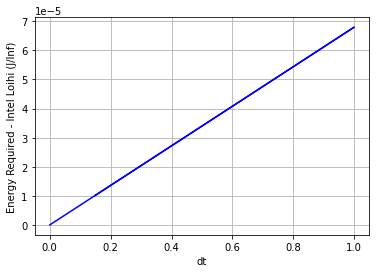

In [56]:
import matplotlib.pyplot as plt
plt.plot(dts, loihi_energies, '-b')
plt.grid()
plt.xlabel('dt')
plt.ylabel('Energy Required - Intel Loihi (J/Inf)')

In [20]:
aware_accuracies = []

for dt in dts:
    acc = check_output(spike_aware_model, modify_dt=dt, plot=False)
    aware_accuracies.append(acc)

Test accuracy: 78.48%
Spike rate per neuron (Hz): min=0.00 mean=28.94 max=200.00
Test accuracy: 84.88%
Spike rate per neuron (Hz): min=0.00 mean=28.95 max=200.00
Test accuracy: 86.72%
Spike rate per neuron (Hz): min=0.00 mean=28.93 max=200.00
Test accuracy: 87.26%
Spike rate per neuron (Hz): min=0.00 mean=28.93 max=200.00
Test accuracy: 87.33%
Spike rate per neuron (Hz): min=0.00 mean=28.93 max=200.00
Test accuracy: 87.21%
Spike rate per neuron (Hz): min=0.00 mean=28.93 max=200.00
Test accuracy: 87.26%
Spike rate per neuron (Hz): min=0.00 mean=28.93 max=200.00
Test accuracy: 87.43%
Spike rate per neuron (Hz): min=0.00 mean=28.93 max=198.00
Test accuracy: 87.35%
Spike rate per neuron (Hz): min=0.00 mean=28.93 max=199.00
Test accuracy: 87.34%
Spike rate per neuron (Hz): min=0.00 mean=28.93 max=198.60
Test accuracy: 87.35%
Spike rate per neuron (Hz): min=0.00 mean=28.93 max=198.60


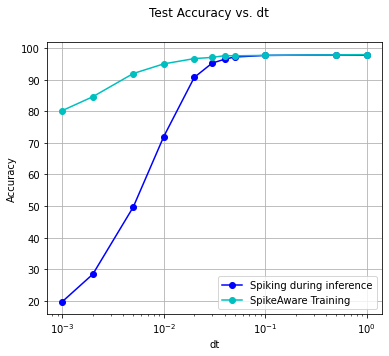

In [111]:
fig, ax = plt.subplots(figsize=(6,5))

ax.plot(dts, accuracies, '-bo')
ax.plot(dts, aware_accuracies, '-co')
ax.grid()

ax.set_xscale('log')

plt.suptitle('Test Accuracy vs. dt')

ax.set_ylabel('Accuracy')
ax.set_xlabel('dt')
ax.legend(['Spiking during inference', 'SpikeAware Training'])

plt.show()